In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
class Point:
    
    def __repr__(self):
        return f'Point({self.loc})'
    
    def __init__(self, loc):
        self.loc = tuple(float(d) for d in loc)
        self.dim = len(loc)

class DirichletControlPoint(Point):
    
    def __repr__(self):
        return f'DirichletControlPoint({self.loc}, val={self.val})'
    
    def __init__(self, loc, val):
        super().__init__(loc)
        self.val = val

In [3]:
class Condition:
    
    def enforce(self, net, *dimensions):
        raise NotImplemented
    
    @staticmethod
    def _nn_output(net, *dimensions):
        original_shape = dimensions[0].shape
        output = net(torch.cat(dimensions, 1))
        return output.reshape(original_shape)

class CustomDirichletBoundaryCondition(Condition):
    
    def __init__(self, dirichlet_control_points, center_point):
        # drop deplicates and sort 'clockwise' (while not changing the original copy)
        dirichlet_control_points = self._clean_control_points(dirichlet_control_points, center_point)
        # fit Dirichlet dummy solution (A_D(x) in MacFall's paper)
        self.a_d = _Interpolator.fit_dirichlet_dummy_solution(dirichlet_control_points)
        # fit Dirichlet length factor (L_D(x) in MacFall's paper)
        self.l_d = _Interpolator.fit_dirichlet_length_factor(dirichlet_control_points)
    
    def enforce(self, net, *dimensions):
        # enforce Dirichlet boundary condition u_t(x) = A_D(x) + L_D(x)u_N(x)
        return self.a_d(*dimensions) + self.l_d(*dimensions)*self._nn_output(net, *dimensions)
    
    @staticmethod
    def _clean_control_points(control_points, center_point):
        # remove the control points that are defined more than once
        locs = set()
        unique_control_points = []
        for cp in control_points:
            if cp.loc not in locs:
                locs.add(cp.loc)
                unique_control_points.append(cp)

        # sort the control points 'clockwise' (from 0 to -2pi)
        def clockwise(cp):
            return (
                1 if cp.loc[1]-center_point.loc[1] > 0 else -1,
                (cp.loc[0]-center_point.loc[0])/(cp.loc[1]-center_point.loc[1]-1e-9)
            )
        unique_control_points.sort(key=clockwise)
        return unique_control_points

In [4]:
class _Interpolator:

    @staticmethod
    def fit_dirichlet_dummy_solution(dirichlet_control_points):
        # specify input and output of thin plate spline
        from_points = dirichlet_control_points
        to_values = [dcp.val for dcp in dirichlet_control_points]
        # fit thin plate spline and save coefficients
        coefs = _Interpolator.solve_thin_plate_spline(from_points, to_values)
        # define closure that map arbitrary points x (represented by torch.tensor 
        # with shape [#point, #dimension]) to A_D(x)
        def a_d(*dimensions):
            return _Interpolator.interpolate_by_thin_plate_spline(coefs, from_points, *dimensions)
        return a_d
        
    @staticmethod
    def fit_dirichlet_length_factor(dirichlet_control_points, radius=0.5):
        # specify input and output of thin plate spline
        from_points = dirichlet_control_points
        to_points = _Interpolator._create_circular_targets(dirichlet_control_points, radius)
        n_dim = to_points[0].dim
        to_values_each_dim = [[tp.loc[i] for tp in to_points] for i in range(n_dim)]
        # fit thin plate spline and save coefficients
        coefs_each_dim = [
            _Interpolator.solve_thin_plate_spline(from_points, to_values)
            for to_values in to_values_each_dim
        ]
        # define closure that map arbitrary points x (represented by torch.tensor 
        # with shape [#point, #dimension]) to L_D(x)
        def l_d(*dimensions):
            dimensions_mapped = [
                _Interpolator.interpolate_by_thin_plate_spline(coefs_dim, from_points, *dimensions)
                for coefs_dim in coefs_each_dim
            ]
            return radius**2 - sum(d**2 for d in dimensions_mapped)
        return l_d
    
    @staticmethod
    def solve_thin_plate_spline(from_points, to_values):
        assert len(from_points) == len(to_values)
        n_dims = from_points[0].dim
        n_pnts = len(from_points)
        n_eqs = n_dims+n_pnts+1
        
        # weights of the eq_no'th equation
        def equation_weights(eq_no):
            
            weights = np.zeros(n_eqs)
            
            # the first M equations (M is the number of control points)
            if eq_no < n_pnts:
                p = from_points[eq_no]
                # the first M weights 
                for i, fp in enumerate(from_points):
                    ri_sq = _Interpolator._ri_sq_thin_plate_spline_pretrain(p, fp)
                    weights[i] = ri_sq * np.log(ri_sq)
                # the M+1'th weight
                weights[n_pnts] = 1.0
                # the rest #dimension weights
                for j in range(n_dims):
                    weights[n_pnts+1+j] = p.loc[j]
            # the M+1'th equation
            elif eq_no <  n_pnts + n_dims:
                j = eq_no - n_pnts
                for i in range(n_pnts):
                    weights[i] = from_points[i].loc[j]
            # the rest #dimension equations
            elif eq_no == n_pnts + n_dims:
                weights[:n_pnts] = 1.0
            else:
                raise ValueError(f'Invalid equation number: {eq_no}')
                
            return weights
        
        # create linear system
        W = np.zeros((n_eqs, n_eqs))
        for eq_no in range(n_eqs):
            W[eq_no] = equation_weights(eq_no)
        b = np.zeros(n_eqs)
        b[:n_pnts] = to_values
        
        # solve linear system and return coefficients
        return np.linalg.solve(W, b)  
    
    # to be used in fitting soefficients of thin plate spline
    def _ri_sq_thin_plate_spline_pretrain(point_i, point_j, stiffness=0.01):
        return sum((di-dj)**2 for di, dj in zip(point_i.loc, point_j.loc)) + stiffness**2
    # to be used in transforming output of neural networks
    def _ri_sq_thin_plate_spline_trainval(point_i, *dimensions, stiffness=0.01):
        return sum((d-di)**2 for di, d in zip(point_i.loc, dimensions)) + stiffness**2
    @staticmethod
    def _create_circular_targets(control_points, radius):
        # create equally spaced target points, this is for 2-d control points
        # TODO 3-d control points
        return [
            Point( (radius*np.cos(theta), radius*np.sin(theta)) )
            for theta in -np.linspace(0, 2*np.pi, len(control_points), endpoint=False)
        ]
    
    def interpolate_by_thin_plate_spline(coefs, control_points, *dimensions):
        n_pnts = len(control_points)
        to_value_unfinished = torch.zeros_like(dimensions[0])
        # the first M basis functions (M is the number of control points)
        for coef, cp in zip(coefs, control_points):
            ri_sq = _Interpolator._ri_sq_thin_plate_spline_trainval(cp, *dimensions)
            to_value_unfinished += coef * ri_sq * torch.log(ri_sq)
        # the M+1'th basis function
        to_value_unfinished += coefs[n_pnts]
        # the rest #dimension basis functions
        for j, d in enumerate(dimensions):
            to_value_unfinished += coefs[n_pnts+1+j] * d
        return to_value_unfinished

In [5]:
control_points_square = []
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(0, i), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(1, i), val=0))
for i in np.linspace(1, 0, 11):
    control_points_square.append(DirichletControlPoint(loc=(i, 0), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(loc=(i, 1), val=0))
    
cdbc = CustomDirichletBoundaryCondition( control_points_square, center_point=Point((0.5, 0.5)) )

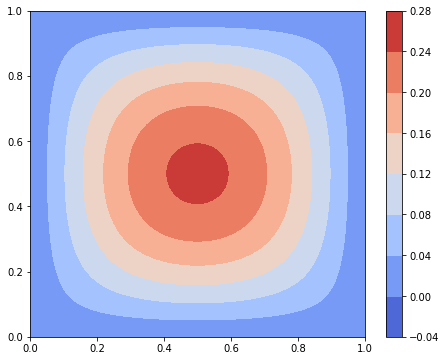

In [6]:
xs = torch.linspace(0, 1, 101)
ys = torch.linspace(0, 1, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ds = cdbc.l_d(xx, yy)
l_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, l_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

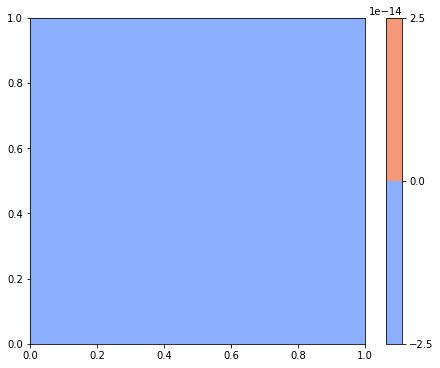

In [7]:
a_ds = cdbc.a_d(xx, yy)
a_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, a_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq import diff
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.ode import IVP, Monitor, solve_system
from scipy.integrate import odeint
from neurodiffeq.pde import DirichletBVP2D, solve2D, ExampleGenerator2D, Monitor2D
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


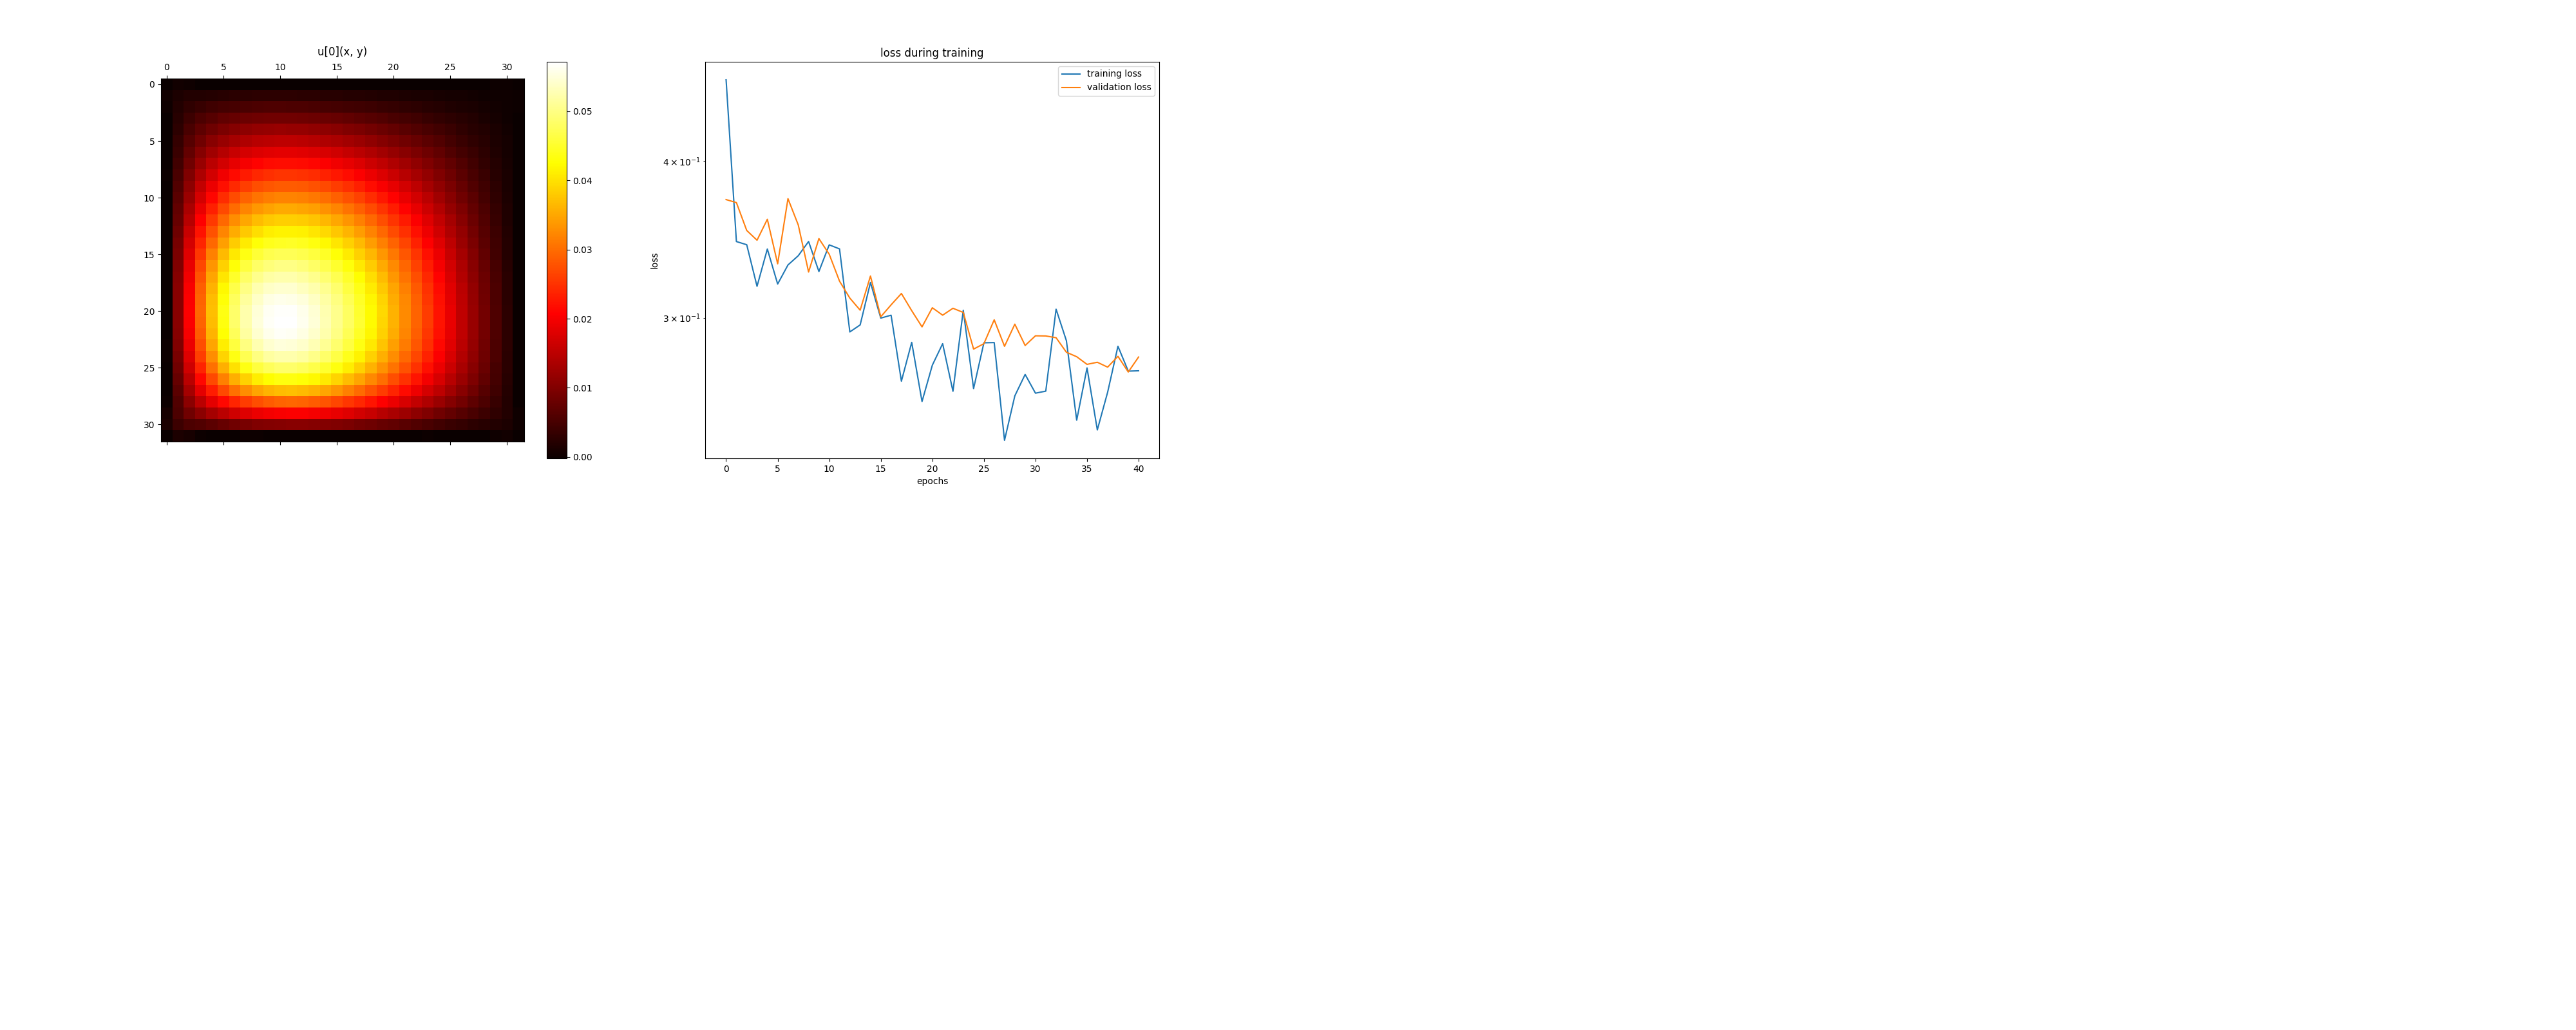

In [9]:
%matplotlib notebook
poisson = lambda u, x, y: diff(u, x, order=2) + diff(u, y, order=2) - 2*x*(y-1)*(y-2*x+x*y+2)*torch.exp(x-y)
# bc = DirichletBVP2D(
#     x_min=0, x_min_val=lambda y: 0, 
#     x_max=1, x_max_val=lambda y: 0, 
#     y_min=0, y_min_val=lambda x: 0, 
#     y_max=1, y_max_val=lambda x: 0
# )
bc = cdbc
net = FCNN(n_input_units=2, n_hidden_units=32, n_hidden_layers=1)

solution_neural_net_poisson, _ = solve2D(
    pde=poisson, condition=bc, xy_min=(0, 0), xy_max=(1, 1),
    net=net, max_epochs=50, train_generator=ExampleGenerator2D(
        (32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'
    ),
    monitor=Monitor2D(check_every=10, xy_min=(0, 0), xy_max=(1, 1))
)
# It is horrobly slow...

In [10]:
xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
solution_analytical_poisson = lambda x, y: np.exp(x-y)*x*(1-x)*y*(1-y)
sol_ana = solution_analytical_poisson(xx, yy)
sol_net = solution_neural_net_poisson(xx, yy, as_type='np')

<IPython.core.display.Javascript object>


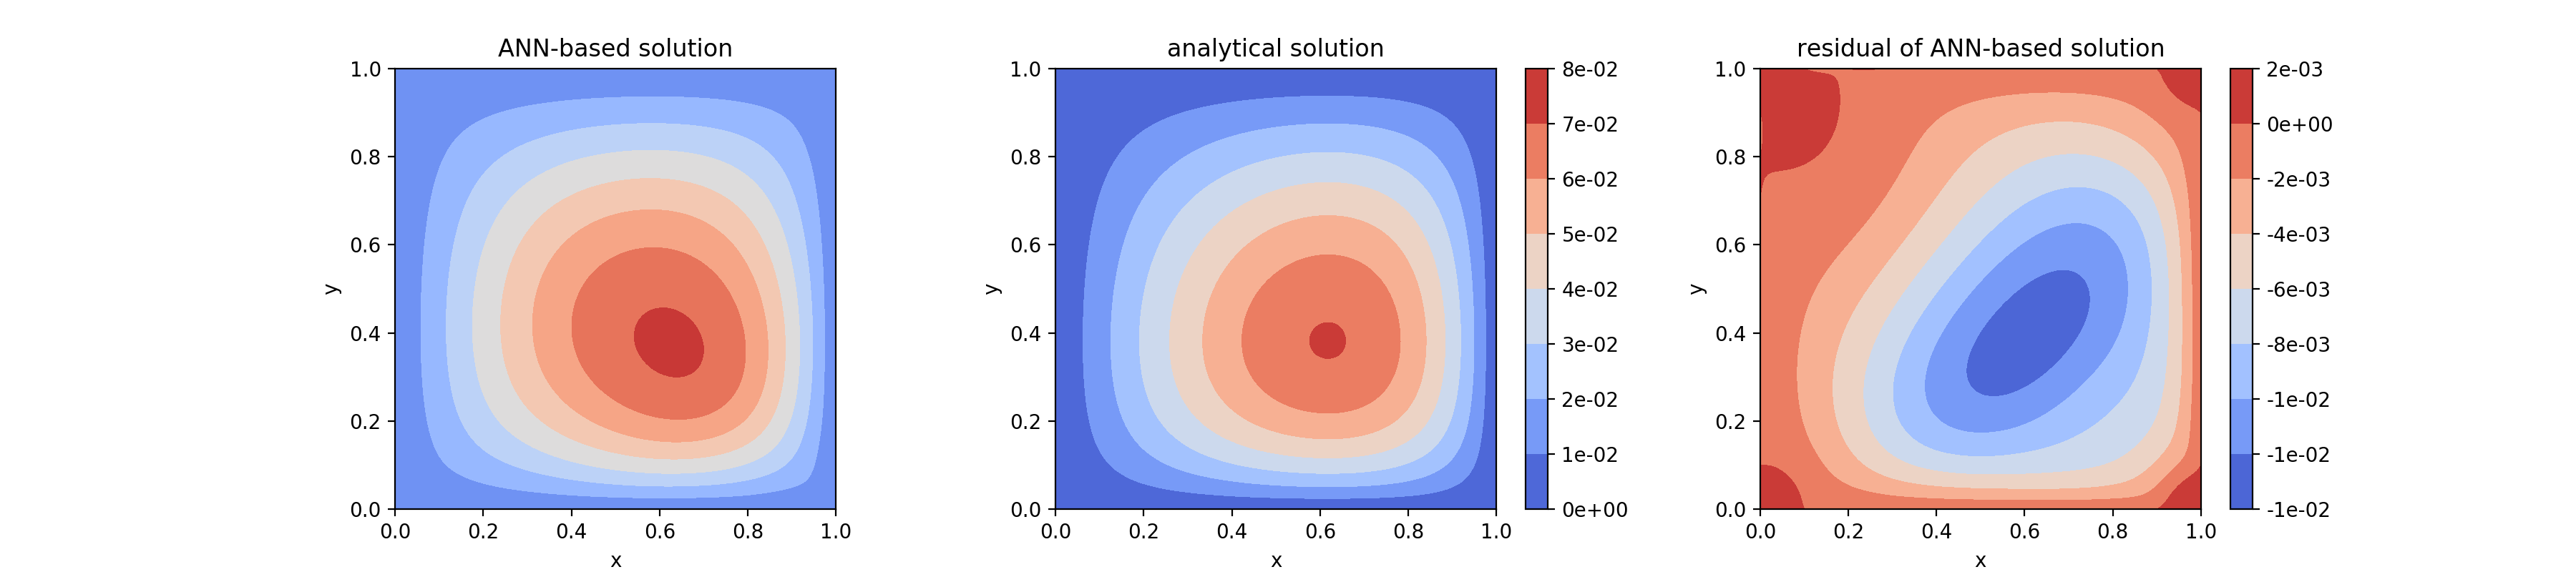

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(18, 4))

ax1 = fig.add_subplot(131)
cs1 = ax1.contourf(xx, yy, sol_net, cmap='coolwarm')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_aspect('equal', adjustable='box')
ax1.set_title('ANN-based solution')

ax2 = fig.add_subplot(132)
cs2 = ax2.contourf(xx, yy, sol_ana, cmap='coolwarm')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal', adjustable='box')
ax2.set_title('analytical solution')
cbar2 = fig.colorbar(cs2, format='%.0e', ax=ax2)

ax3 = fig.add_subplot(133)
cs3 = ax3.contourf(xx, yy, sol_net-sol_ana, cmap='coolwarm')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_aspect('equal', adjustable='box')
ax3.set_title('residual of ANN-based solution')
cbar3 = fig.colorbar(cs3, format='%.0e', ax=ax3)